In [1]:
import numpy as np 
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import ReduceLROnPlateau

In [3]:
train_df = pd.read_csv(r"C:\Users\betsy\Desktop\project\sign_language_recognition_system\dataset\sign_mnist_train.csv")
test_df = pd.read_csv(r"C:\Users\betsy\Desktop\project\sign_language_recognition_system\dataset\sign_mnist_test.csv")

In [4]:
test = pd.read_csv(r"C:\Users\betsy\Desktop\project\sign_language_recognition_system\dataset\sign_mnist_test.csv")
y = test['label']

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Data Visualization and Preprocessing¶

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

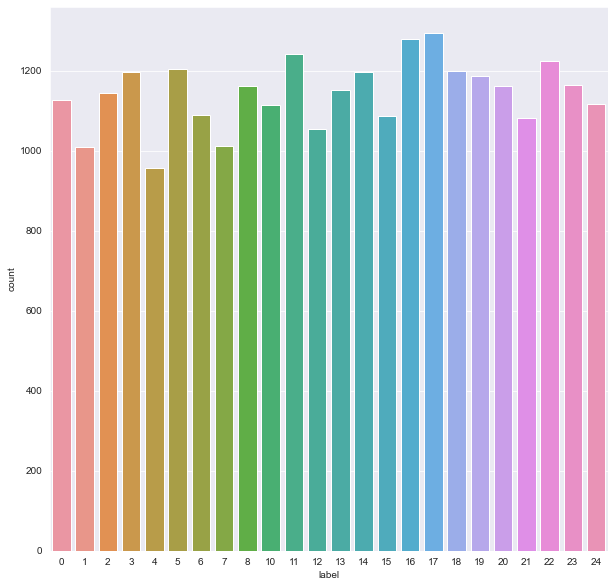

In [6]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [7]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [9]:
x_train = train_df.values
x_test = test_df.values

In [10]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [11]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

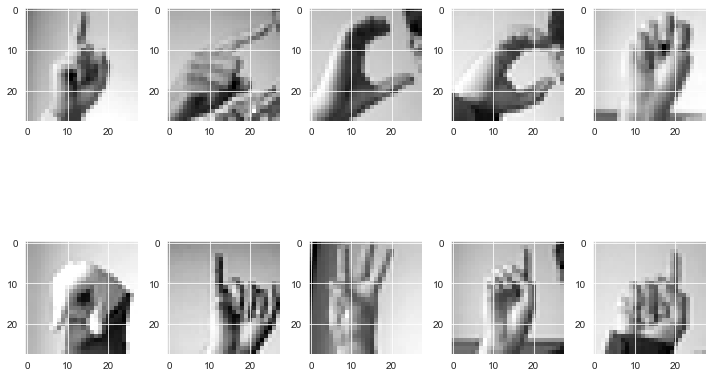

In [12]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout() 

In [13]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Training the model¶

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [15]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [16]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 61s 279ms/step - loss: 1.0973 - accuracy: 0.6593 - val_loss: 3.6217 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 61s 281ms/step - loss: 0.2100 - accuracy: 0.9313 - val_loss: 1.7721 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 60s 281ms/step - loss: 0.1018 - accuracy: 0.9669 - val_loss: 0.4351 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 61s 285ms/step - loss: 0.0652 - accuracy: 0.9788 - val_loss: 0.0348 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 61s 281ms/step - loss: 0.0433 - accuracy: 0.9862 - val_loss: 0.0449 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 63s 294ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 0.0206 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 7/20
215/215 [==============================] 

In [17]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 4s 16ms/step - loss: 4.0830e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


### Analysis after Model Training¶

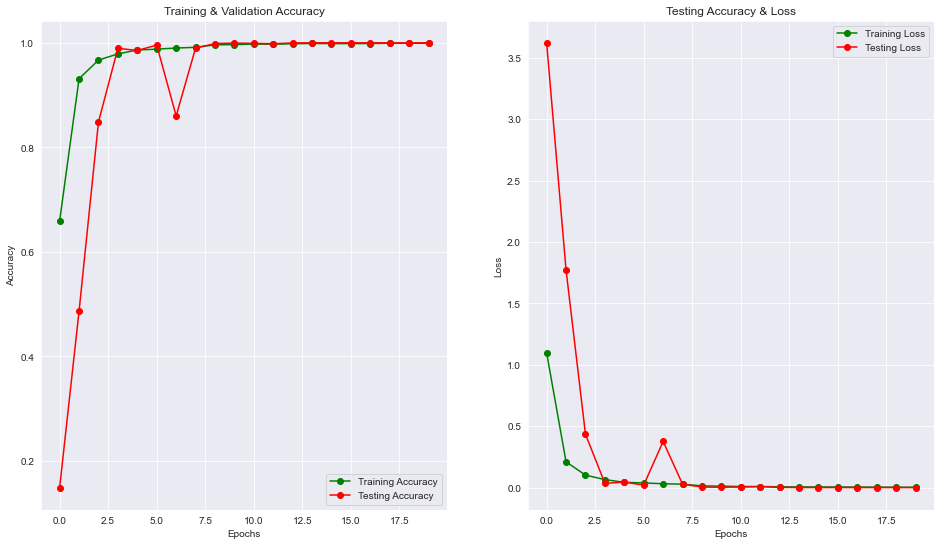

In [18]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]      


225/225 [==============================] - 4s 16ms/step


array([ 6,  5, 10,  0,  3], dtype=int64)

In [20]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [21]:
correct = (predictions == y).to_numpy().nonzero()[0]

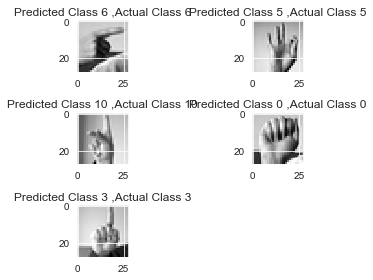

In [22]:
i = 0
for c in correct[:5]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {} ,Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [23]:
import joblib
joblib.dump(model,'saved.joblib')

INFO:tensorflow:Assets written to: ram://5fa673aa-6c0b-4296-9aa1-c91dd46d2b72/assets


INFO:tensorflow:Assets written to: ram://5fa673aa-6c0b-4296-9aa1-c91dd46d2b72/assets


['saved.joblib']